<a href="https://colab.research.google.com/github/nikiska77/ydata-viz-ai/blob/main/NN_sharing_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#install packages

In [2]:

!pip install wget
!pip install -U git+https://github.com/pydicom/pydicom.git
#pip install --no-cache-dir git+https://github.com/pydicom/pydicom.git
!pip install python-gdcm

!pip install torchsummary 



  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=6eb4c518cb3b12404324baa0ff23718dab9a3a76fa802746b0909e6ae6716ed3
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Cloning https://github.com/pydicom/pydicom.git to /tmp/pip-req-build-c4vqcdza
  Running command git clone -q https://github.com/pydicom/pydicom.git /tmp/pip-req-build-c4vqcdza
  Created wheel for pydicom: filename=pydicom-2.4.0.dev0-py3-none-any.whl size=1964280 sha256=ff0b7f36af729f3946cb9540281c7e2e6cf0d5b92a4bd02a99aaa8534df5fff3
  Stored in directory: /tmp/pip-ephem-wheel-cache-g0ylqdxf/wheels/8a/75/6f/a3a81ff6d9eaa04f50d99238b899485b32c5948527a33b243c
Successfully built pydicom
     |████████████████████████████████| 12.6 MB 26.9 MB/s 


In [163]:
import dicom_utils as dcm
import Affine3D as affine
from scipy.ndimage import affine_transform

In [ ]:
#input_file = "/Users/boriskefer/Documents/coding/YDATA/2021_2022_main/viz_ai/ydata-viz-ai/YdataDataset.txt" 
#data_path = "/Users/boriskefer/Documents/coding/YDATA/2021_2022_main/viz_ai/ydata-viz-ai/data03_01"

In [4]:
#to work from Colab and google disk:
from google.colab import drive 
from pathlib import Path
import os

drive.mount('/content/drive')

home_path = Path("/content/drive/MyDrive/VIZ/data/data03_01")
#data_path = os.path.join(home_path, "data")
#print(data_path)

Mounted at /content/drive


In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import copy

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid

#Model

In [ ]:
x = torch.rand(1,3,64,64) # input x
y = torch.rand(1,3,64,64) # input y
cnn = nn.Conv2d(3,10,kernel_size=5) # network
input = torch.cat((x,y),dim=0) # stack them batch-wise
output = cnn(input) # pass both x and y through the network as a single pass
x_out = output[0] # get the output of x
y_out = output[1] # get the output of y

### Variant 1 (concatenating the input)

In [6]:
class Our_AirNet(nn.Module):
    def __init__(self):
        super(Our_AirNet, self).__init__()
        self.flatten = nn.Flatten()
        self.firstlayer = nn.Sequential(
            #how many channels do we have?? 
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            #(320 - 3 + 2*1)/1 + 1 = 320
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #(320 - 2)/2 + 1 = 160
        self.transition = nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=1,stride=1,padding=0),
            #(160 - 1 )/1 + 1 
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #80
        self.regression = nn.Sequential(
            #we have to double here because the images will be concatenated
            nn.Linear(20*20*20, 1024),
            #nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
           # nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
           # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
           # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 12))    
        
    def forward(self, x, y):
        inp = torch.cat((x,y),dim=0) # stack them batch-wise
        inp = self.firstlayer(inp)
        inp = self.transition(inp) #80
        inp = self.transition(inp) #40
        inp = self.transition(inp) #20
        #input_conc = torch.cat((inp[:x.shape[0]],inp[x.shape[0]:]),dim=1)
        inp = self.flatten(inp)
        res = self.regression(inp)
        return res        



In [13]:
model = Our_AirNet()
summary(model, (20, 320, 320), batch_size=1)

In [34]:
'''
a = torch.rand(1,3,5,5) # input a
print(a.shape)
b = torch.rand(1,3,5,5) # input b
print(b.shape)
c = torch.cat((a,b),dim=1) # stack them batch-wise
n=a.shape[0]
c.shape
d = torch.cat((c[:a.shape[0]],c[a.shape[0]:]),dim=1)
d.shape
#print(input_conc)
c[:a.shape[0]].shape

a = a.flatten()
a.shape
b = b.flatten()
c.shape
c = torch.cat((a,b), dim=0)
'''

torch.Size([150])

In [170]:
def normalize(img, min_val, max_val):
    return (img - min_val) / (max_val - min_val)

def transform(img):
    alpha = np.random.randint(-45, 45)
    m = affine.Affine3dRotateCenterMatrix(alpha, img.shape, axis=2)
    return affine.affine_transform(img, m), m

class Img3dDataSet(Dataset):
    def __init__(self, data_path, min_val, max_val):
        self.d_path = data_path
        self.min_val = min_val
        self.max_val = max_val
        self.transform = None
        self.target_transform = None
        names = [f for f in os.listdir(data_path) if f.endswith(".npz")]
        self.names_array = np.sort(np.array(names))
        
    def __getitem__(self, idx):
        name = self.names_array[idx]
        img3d = np.load(os.path.join(self.d_path, name))['I']
        img3d = normalize(img3d, self.min_val, self.max_val)
        label, matrix = transform(img3d)
        print(label.shape, matrix.shape)
        matrix = matrix[:3,:]
        print(matrix)
        label = label.transpose(2, 0, 1)
        label = torch.from_numpy(label).float()
        #adding this to get the dimensions nedded
        img3d = img3d.transpose(2, 0, 1)
        #print(img3d.shape , label.shape)
        item = torch.from_numpy(img3d).float()
        return item, label, matrix
    
    def __len__(self):
        return len(self.names_array)

In [171]:
dataset = Img3dDataSet(home_path, -1000, 1000)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [172]:
%%time
x, y, matrix = next(iter(dataloader))

(320, 320, 20) (4, 4)
[[  0.7431448   0.6691306   0.        -65.964066 ]
 [ -0.6691306   0.7431448   0.        148.15773  ]
 [  0.          0.          1.          0.       ]]
CPU times: user 957 ms, sys: 7.26 ms, total: 964 ms
Wall time: 1.57 s


In [ ]:
x.shape, y.shape, matrix.shape

tensor([[[  0.7880,  -0.6157,   0.0000, 132.4241],
         [  0.6157,   0.7880,   0.0000, -64.5876],
         [  0.0000,   0.0000,   1.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]]])

In [ ]:
matrix1 = matrix[:,:3,:]

tensor([[[  0.7880,  -0.6157,   0.0000, 132.4241],
         [  0.6157,   0.7880,   0.0000, -64.5876],
         [  0.0000,   0.0000,   1.0000,   0.0000]]])

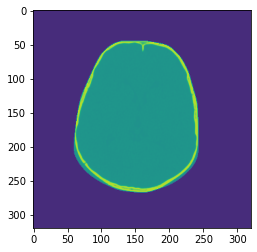

In [ ]:
plt.imshow(x[0][:,:,10])

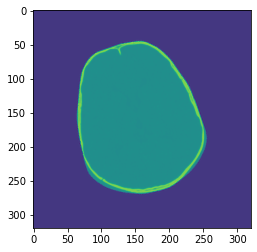

In [ ]:
plt.imshow(y[0][:,:,10])

#Running model

In [92]:
model = Our_AirNet()
model.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr = 0.005 )
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 70

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([2, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch number 0
 Current loss 499.8522033691406

Epoch number 1
 Current loss 2708.3642578125

Epoch number 2
 Current loss 488.0892639160156

Epoch number 3
 Current loss 357.0513916015625

Epoch number 4
 Current loss 134.46176147460938

Epoch number 5
 Current loss 176.9114990234375

Epoch number 6
 Current loss 68.71552276611328

Epoch number 7
 Current loss 88.98954010009766

Epoch number 8
 Current loss 46.9998779296875

Epoch number 9
 Current loss 49.115692138671875

Epoch number 10
 Current loss 25.858919143676758

Epoch number 11
 Current loss 27.08823013305664

Epoch number 12
 Current loss 25.137821197509766

Epoch number 13
 Current loss 16.13767433166504

Epoch number 14
 Current loss 10.77726936340332

Epoch number 15
 Current loss 5.467897415161133

Epoch number 16
 Current loss 8.987089157104492

Epoch number 17
 Current loss 8.426682472229004

Epoch number 18
 Current loss 7.486973285675049

Epoch number 19
 Current loss 5.0028462409973145

Epoch number 20
 Current los

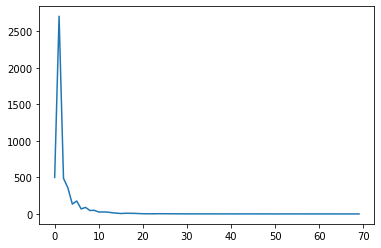

In [93]:
best_loss = np.inf
loss_history = [] 
best_model_wts = copy.deepcopy(model.state_dict())
#iteration_number= 0

# Iterate throught the epochs
for epoch in range(num_epochs):

    # Iterate over batches
#    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
 #       img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
  

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        res = model(x, y)

        # Pass the outputs of the networks and label into the loss function
        loss = criterion(res, matrix.flatten())
        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()
        scheduler.step() 
        # Every 10 batches print out the loss
#        if i % 10 == 0 :
        print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
        #iteration_number += 10

        if best_loss > loss:
          best_loss = loss
          best_model_wts = copy.deepcopy(model.state_dict())

        loss_history.append(loss.item())



print(f'Best loss {best_loss}')

plt.plot(range(num_epochs),loss_history)
plt.show()
model.load_state_dict(best_model_wts)
#y.shape

In [103]:
#Printing the input and output
print('the input')
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
x_to_print = x[0].numpy()
x_to_print = x_to_print.transpose(1, 2, 0)
plt.imshow(x_to_print[:,:,10])
plt.subplot(1,2,2)
y_to_print = y[0].numpy()
y_to_print = y_to_print.transpose(1, 2, 0)
plt.imshow(y_to_print[:,:,10])


print('the output of the model')
model.load_state_dict(best_model_wts)
result_matrix = model(x, y)


tensor([[ 9.8147e-01, -8.1401e-03,  5.1716e-03,  1.1570e+01,  7.4433e-02,
          1.0004e+00, -2.1785e-02, -1.0747e+01, -5.9782e-03, -1.8252e-02,
          1.0093e+00,  2.6488e-02],
        [ 9.7994e-01, -8.4565e-03,  4.6730e-03,  1.1575e+01,  7.3543e-02,
          1.0003e+00, -2.2586e-02, -1.0752e+01, -6.4863e-03, -1.8585e-02,
          1.0096e+00,  2.7398e-02]], grad_fn=<AddmmBackward0>)

###Variant2 (Siamese network)

In [124]:
class Siam_AirNet(nn.Module):
    def __init__(self):
        super(Siam_AirNet, self).__init__()
        self.flatten = nn.Flatten()
        self.firstlayer = nn.Sequential(
            #how many channels do we have?? 
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            #(320 - 3 + 2*1)/1 + 1 = 320
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #(320 - 2)/2 + 1 = 160
        self.transition = nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=1,stride=1,padding=0),
            #(160 - 1 )/1 + 1 
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #80
        self.regression = nn.Sequential(
            #we have to double here because the images will be concatenated
            nn.Linear(20*20*20*2, 1024),
            #nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
           # nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
           # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
           # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 12))   

    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.firstlayer(x)
        output = self.transition(output)
        output = self.transition(output)
        output = self.transition(output)
        output = self.flatten(output)        
        return output

    def forward(self, input_t, input_ref):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        input_t = self.forward_once(input_t)
        #print(input_t.shape)
        input_ref = self.forward_once(input_ref)
        #print(input_ref.shape)
        input_conc = torch.cat((input_t,input_ref),dim=1)
        #print(input_conc.shape)
        res = self.regression(input_conc)
        return res 

In [240]:
model2 = Siam_AirNet()
model2.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model2.parameters(), lr = 0.005 )
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 100

tensor([[-0.1079,  0.0009, -0.0952,  0.0891, -0.0733,  0.0927,  0.0824, -0.1054,
         -0.1101,  0.0119, -0.0752, -0.0270]], grad_fn=<AddmmBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch number 0
 Current loss 26348.10546875

tensor([[ 15.4814,  14.5704,   8.2264, -16.1322,   6.2891,   8.9244,   5.1405,
          24.5399,   5.4251,  15.3138, -11.5637, -12.7230]],
       grad_fn=<AddmmBackward0>)
Epoch number 1
 Current loss 18968.14453125

tensor([[  26.5406,   69.8647,  -12.1354, -116.7974,   11.8034,   26.3585,
           44.7188,  208.6897,   33.9906,   46.6249,  -53.7789,  -59.4159]],
       grad_fn=<AddmmBackward0>)
Epoch number 2
 Current loss 24520.640625

tensor([[ -0.5456,  10.2963,  -3.6010, -30.9974,   1.3422,   2.8710,   3.7563,
          51.1311,   6.0065,   4.6719,  -8.0542, -10.6681]],
       grad_fn=<AddmmBackward0>)
Epoch number 3
 Current loss 11020.5224609375

tensor([[ -2.7820,  -2.8595,   3.1795, -21.6360,  -0.7896,  -0.9539,  -5.1768,
          31.2544,   4.2808,  -1.1658,  -2.8272,  -3.5445]],
       grad_fn=<AddmmBackward0>)
Epoch number 4
 Current loss 15742.943359375

tensor([[-2.1018e+00, -8.2956e+00,  9.2728e+00, -2.7243e+01, -2.2259e+

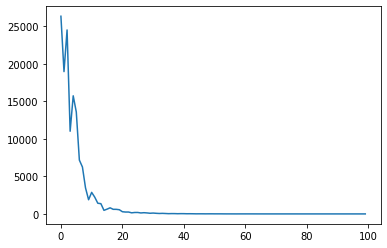

<All keys matched successfully>

In [241]:
best_loss = np.inf
loss_history = [] 
best_model_wts2 = copy.deepcopy(model2.state_dict())
#iteration_number= 0

# Iterate throught the epochs
for epoch in range(num_epochs):

    # Iterate over batches
#    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
 #       img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
  

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        res = model2(x, y)
        print(res)

        # Pass the outputs of the networks and label into the loss function
        loss = criterion(res, matrix.flatten())
        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()
        scheduler.step() 
        # Every 10 batches print out the loss
#        if i % 10 == 0 :
        print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
        #iteration_number += 10

        if best_loss > loss:
          best_loss = loss
          best_model_wts2 = copy.deepcopy(model2.state_dict())

        loss_history.append(loss.item())
print(f'Best loss {best_loss}')

plt.plot(range(num_epochs),loss_history)
plt.show()
model2.load_state_dict(best_model_wts2)


### Model output check

the input


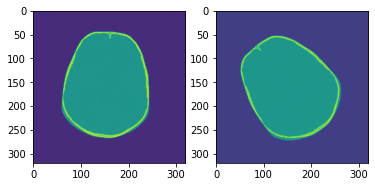

In [174]:
#Printing the input and output
print('the input')
fig = plt.subplots(1,2)
plt.subplot(1,2,1)
x_to_print = x[0].numpy()
x_to_print = x_to_print.transpose(1, 2, 0)
plt.imshow(x_to_print[:,:,10])
plt.subplot(1,2,2)
y_to_print = y[0].numpy()
y_to_print = y_to_print.transpose(1, 2, 0)
plt.imshow(y_to_print[:,:,10])




In [237]:
print('the output of the model')

result_matrix = model2(x, y)
result_matrix = result_matrix.detach().numpy()
print(y.sum())
result_matrix_new = np.append(result_matrix,[0, 0, 0, 1]).reshape(4,4)
result_matrix.shape
x_nmp = x.detach().numpy()[0].transpose(1, 2, 0)
print(x_nmp.sum())
plt.imshow(x_nmp[:,:,10])
x_new = affine_transform(x_nmp, result_matrix_new)
print(x_new.sum())
plt.imshow(x_new[:,:,10])

m_check = np.array([[0.7431448, 0.6691306, 0., -65.964066 ],
 [-0.6691306, 0.7431448, 0., 148.15773],
 [0.,0., 1., 0.]])
m_check = m_check.flatten()


err = np.sum(np.power(np.subtract(m_check, result_matrix),2))/12

y_nmp.shape

mse = nn.MSELoss()
m_check_tensor = torch.tensor(m_check)
matrix_tensor = torch.tensor(result_matrix)
print(mse(m_check_tensor, matrix_tensor))
print(err)

tensor(2622.1957, dtype=torch.float64)
2622.1956799693003


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [247]:
res.detach().numpy()

array([[ 7.4034929e-01,  6.4061707e-01,  5.7641596e-02, -6.5982307e+01,
        -7.3480856e-01,  7.7782649e-01, -4.3678321e-02,  1.4828378e+02,
        -7.5638726e-02, -2.7268361e-03,  8.7950772e-01, -1.6354546e-02]],
      dtype=float32)

In [262]:
x_65 = torch.tensor(np.array([  1.0197,   0.2484,  -0.4615, -65.7467,  -0.9316,   0.5529,  -0.8590,
         147.3966,  -0.2259,   0.2153,   1.0492,  -0.2639]))
x_65.shape

torch.Size([12])

In [272]:
mse(m_check_tensor, res)
mse(m_check_tensor, x_65)

tensor([[ 7.4035e-01,  6.4062e-01,  5.7642e-02, -6.5982e+01, -7.3481e-01,
          7.7783e-01, -4.3678e-02,  1.4828e+02, -7.5639e-02, -2.7268e-03,
          8.7951e-01, -1.6355e-02]], grad_fn=<AddmmBackward0>)

In [289]:
res_matrix = x_65.detach().numpy()
x_new = affine_transform(x_nmp, res_matrix.reshape(3,4))
print(x_nmp.sum(), x_new.sum())
plt.imshow(x_new[:,:,10])


285767.1 62875.53
